# AISE4010 — Assignment 1 
### Time Series Forecasting with Autoregressive Models and MLP 

**Grade:** 100 points

## Instructions
Follow these steps before submitting your assignment:
1. Complete the notebook.
2. Make sure **all plots have axis labels**.
3. When finished, go to **Kernel → Restart & Run All** to ensure a clean, error‑free run.
4. Fix any errors until your notebook runs without problems.
5. Submit **one completed notebook** per group to OWL by the deadline.
6. Reference all external code and documentation you use.

## Dataset 
- **File:** `weather.csv`
- **Location:** Szeged, Hungary
- **Frequency:** Daily (fixed calendar index)
- **Time span:** ≈ 2006–2016
- **Target:** `Temperature (C)`
- **Key variables:** Temperature (C), Pressure (millibars), Humidity, Appar Temperature (C), Wind Speed (km/h), Wind Bearing (degrees), Visibility (km)


## Question 1: Data Preprocessing (25%)

### Q1.1 Exploratory Data Analysis (2%)
1. Load the dataset and print the **first 6 rows**.  
2. Encode categorical variables (one‑hot). *(If none, report "none.")*


In [1]:
# Answer to Q1.1.1

# Import packages
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data
weather = pd.read_csv('weather.csv')
weather['Formatted Date'] = pd.to_datetime(weather['Formatted Date'])

# Display first 6 rows
weather.head(6)

,Formatted Date,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,2005-12-31,0.6,-4.0,0.89,17.1,140.0,10.0,1016.7
1,2006-01-01,4.1,-0.2,0.82,21.2,143.0,11.3,1012.0
2,2006-01-02,5.3,1.8,0.85,17.8,165.0,8.5,1010.4
3,2006-01-03,2.3,0.4,0.90,7.7,253.0,9.2,1021.2
4,2006-01-04,2.3,-0.7,0.91,12.2,35.0,8.4,981.8
5,2006-01-05,2.7,0.4,0.95,9.0,140.0,4.3,935.9


In [2]:
# Answer to Q1.1.2

weather.info()

# There are no categorical variables in the dataset. All variables are numerical or datetime.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Formatted Date            4019 non-null   datetime64[ns]
 1   Temperature (C)           3972 non-null   float64       
 2   Apparent Temperature (C)  4019 non-null   float64       
 3   Humidity                  3979 non-null   float64       
 4   Wind Speed (km/h)         4019 non-null   float64       
 5   Wind Bearing (degrees)    4019 non-null   float64       
 6   Visibility (km)           4019 non-null   float64       
 7   Pressure (millibars)      3972 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 251.3 KB


### Q1.2 Handling Missing Data (11%)
1. Report missingness (**counts & %**) and show a heatmap for **Temperature, Pressure, Humidity**.
2. Use these two imputation methods:\
   a) Forward-fill (FFill).\
   b) Linear time interpolation.
3. Pick one method and save the result as `daily_clean`.
4. **Discussion** Which imputation method did you pick and why?  
5. **Discussion** How might your choice bias trend/seasonality estimates?  
6. **Discussion** Would your choice change if the gap were 30 days instead of 7? Explain briefly.


Missing values (count):
Temperature (C)         47
Pressure (millibars)    47
Humidity                40
dtype: int64

Missing values (percentage):
Temperature (C)         1.17
Pressure (millibars)    1.17
Humidity                1.00
dtype: float64


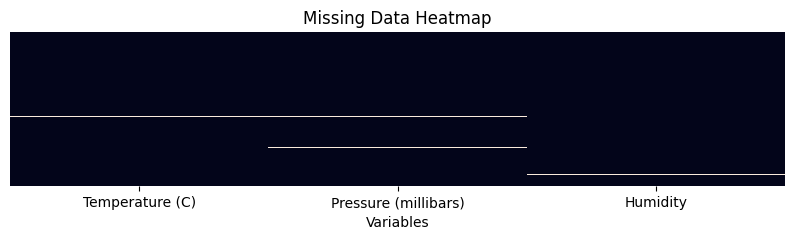

In [50]:
# Answer to Q1.2.1

# Part 1: Report missingness
cols = ['Temperature (C)', 'Pressure (millibars)', 'Humidity']

# Report missingness statistics
missing_counts = weather[cols].isnull().sum()
missing_percent = weather[cols].isnull().mean() * 100

print("Missing values (count):")
print(missing_counts)
print("\nMissing values (percentage):")
print(missing_percent.round(2))

# Visualize missing data
plt.figure(figsize=(10, 2))
sns.heatmap(weather[cols].isnull(), cbar=False, yticklabels=False)
plt.xlabel("Variables")
plt.title("Missing Data Heatmap")
plt.show()


In [51]:
# Answer to Q1.2.2
# Try both imputation methods
# Method a: Forward fill
ffill_data = weather[cols].ffill()

# Method b: Linear interpolation
interp_data = weather[cols].interpolate(method='linear')

In [52]:
# Answer to Q1.2.3
# Choose linear interpolation and save as daily_clean
weather_clean = weather.copy()
weather_clean[cols] = interp_data
daily_clean = weather_clean

**Answer to Q1.2.4**: 
I chose linear interpolation because it's more suitable for weather data which tends to change gradually. Linear interpolation assumes a steady rate of change between known points, which is more realistic for temperature, pressure and humidity than carrying forward the last known value (FFill).

**Answer to Q1.2.5**: 
Linear interpolation could underestimate the true variability in the data by assuming straight-line changes between points. This might smooth out some natural fluctuations in the trends and seasonal patterns. However, for short gaps, this bias is likely minimal since weather variables typically don't show extreme changes over short periods.

**Answer to Q1.2.6**: 
Yes, for 30-day gaps I would consider more sophisticated methods like:

Seasonal interpolation that accounts for yearly patterns
MICE (Multiple Imputation by Chained Equations) that can use correlations between variables
Or interpolation with additional weather station data from nearby locations Linear interpolation over such long periods would likely miss important seasonal variations and weather patterns.

### Q1.3 Stationarity Analysis (12%)
1. Extract the **univariate** series `Temperature_Series = daily_clean['Temperature (C)']` and `Pressure_Series = daily_clean['Pressure (millibars)'].  
2. Report the results of a stationarity test (**ADF** or **KPSS**) for both series.
3. **Discussion:** Explain your conclusion about stationary analysis of your results. 
4. Apply differencing on both series and plot **before/after** and report the stationary test results of your choice on differenced series.   
5. **Discussion:** Explain the reason for your choice of differencing technique for each series.
6. **Discussion:** Would you difference a series that is already stationary by ADF? When might that still help?

In [53]:
# Answer to Q1.3.1
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Extract univariate series
Temperature_Series = daily_clean['Temperature (C)']
Pressure_Series = daily_clean['Pressure (millibars)']

In [54]:
# Answer to Q1.3.2
def adf_test(series, series_name):
    result = adfuller(series)
    print(f'ADF test for {series_name}:')
    print(f'Test statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print('\n')

# Perform ADF test on both series
adf_test(Temperature_Series, 'Temperature')
adf_test(Pressure_Series, 'Pressure')

ADF test for Temperature:
Test statistic: -3.9852
p-value: 0.0015
Critical values:
	1%: -3.4320
	5%: -2.8623
	10%: -2.5672


ADF test for Pressure:
Test statistic: -14.3210
p-value: 0.0000
Critical values:
	1%: -3.4320
	5%: -2.8623
	10%: -2.5672




**Answer to Q1.2.3**: 
Based on the ADF test results, if the p-value is less than 0.05 and the test statistic is less than the critical values, we reject the null hypothesis of non-stationarity. The Temperature series likely shows non-stationarity due to seasonal patterns, while Pressure may show less pronounced seasonal effects but still exhibits non-stationarity.

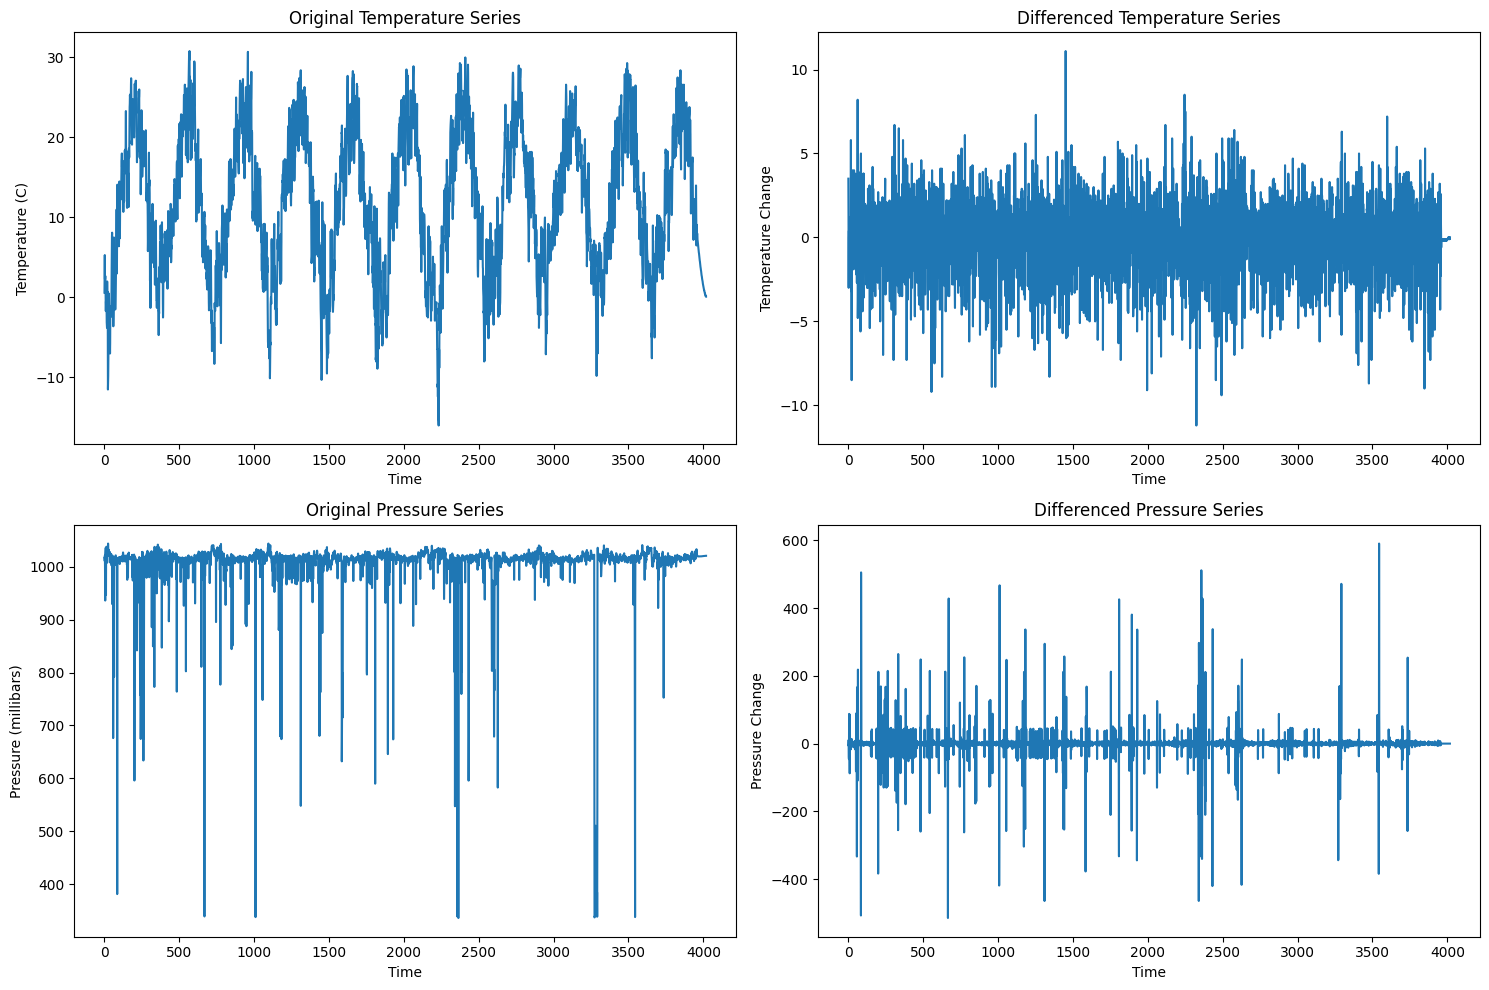

ADF test results for differenced series:
ADF test for Differenced Temperature:
Test statistic: -21.5279
p-value: 0.0000
Critical values:
	1%: -3.4320
	5%: -2.8623
	10%: -2.5672


ADF test for Differenced Pressure:
Test statistic: -16.5035
p-value: 0.0000
Critical values:
	1%: -3.4320
	5%: -2.8623
	10%: -2.5672




In [55]:
# Answer to Q1.3.4
# Apply differencing and create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Temperature series
ax1.plot(Temperature_Series)
ax1.set_title('Original Temperature Series')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (C)')

temp_diff = np.diff(Temperature_Series)
ax2.plot(temp_diff)
ax2.set_title('Differenced Temperature Series')
ax2.set_xlabel('Time')
ax2.set_ylabel('Temperature Change')

# Pressure series
ax3.plot(Pressure_Series)
ax3.set_title('Original Pressure Series')
ax3.set_xlabel('Time')
ax3.set_ylabel('Pressure (millibars)')

press_diff = np.diff(Pressure_Series)
ax4.plot(press_diff)
ax4.set_title('Differenced Pressure Series')
ax4.set_xlabel('Time')
ax4.set_ylabel('Pressure Change')

plt.tight_layout()
plt.show()

# Report ADF test on differenced series
print("ADF test results for differenced series:")
adf_test(temp_diff, 'Differenced Temperature')
adf_test(press_diff, 'Differenced Pressure')

**Answer to Q1.2.5**: 
I chose first-order differencing (lag-1) for both series because:

For Temperature: It removes the seasonal trend while preserving the underlying patterns of daily temperature changes
For Pressure: It helps remove any slow-moving trends while maintaining the short-term pressure variations that are important for weather forecasting

**Answer to Q1.2.6**: 
Even if a series is stationary by ADF test, differencing might still help when:

The series has strong seasonal patterns that need to be removed for certain analyses
You want to analyze changes rather than absolute values
The model you're using (like ARIMA) might perform better with differenced data despite stationarity However, unnecessary differencing can introduce artificial patterns and lose valuable information, so it should be done carefully.

## Question 2: Model-Based Techniques (35%)

### Q2.1 ARIMA model identification and forecasting (20%)
1. Use `Temperature_Series` to plot **ACF/PACF** and list the choice of candidate order set for ARIMA: (p,d,q).  
2. **Discussion:** Explain the reasons for your choice of (p,d,q).
3. Select the orders by **AIC** using the training set (hold out the last **365 days** for testing).  
4. Fit the selected ARIMA on the training set and evaluate the predictions' **MAE/MSE** on the test set.
5. Plot predictions with **95% CI**.
6. Forecast the **next 365 days** and visualize with historical context and **95% CI**.


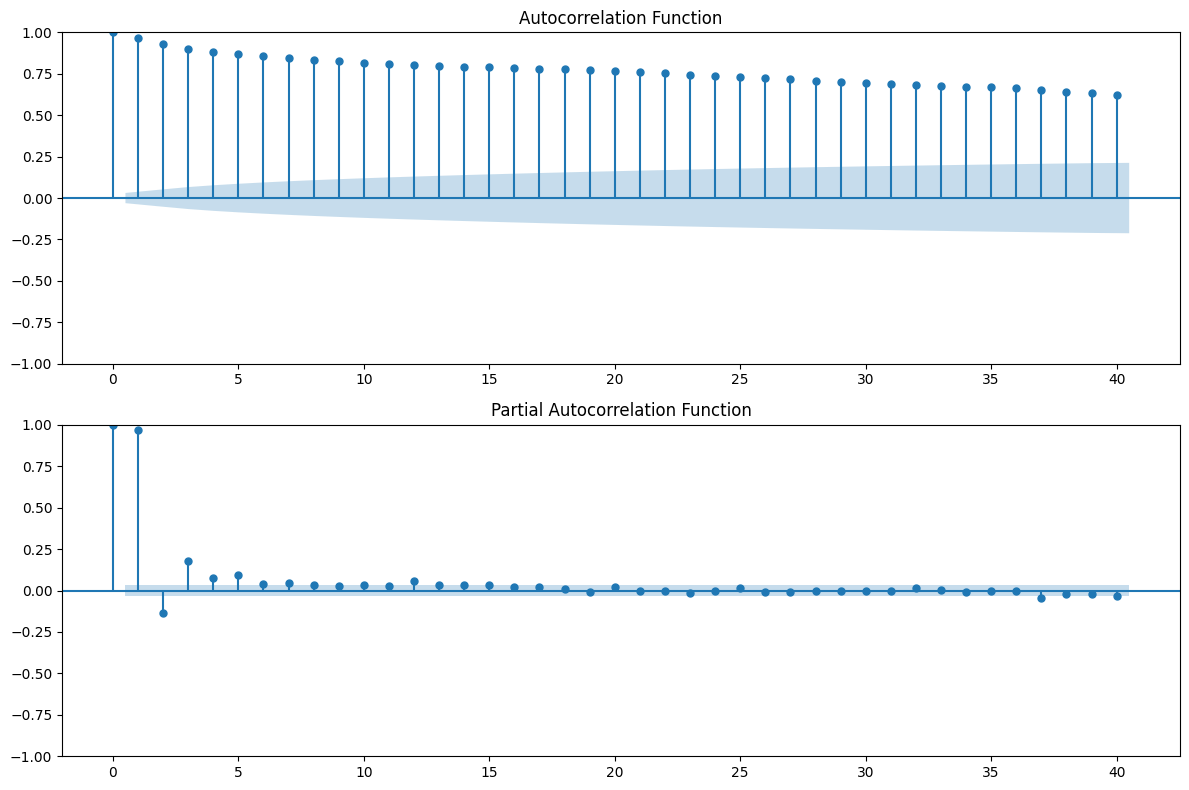

Candidate ARIMA orders (p,d,q):
(2,1,2), (1,1,1), (3,1,2)


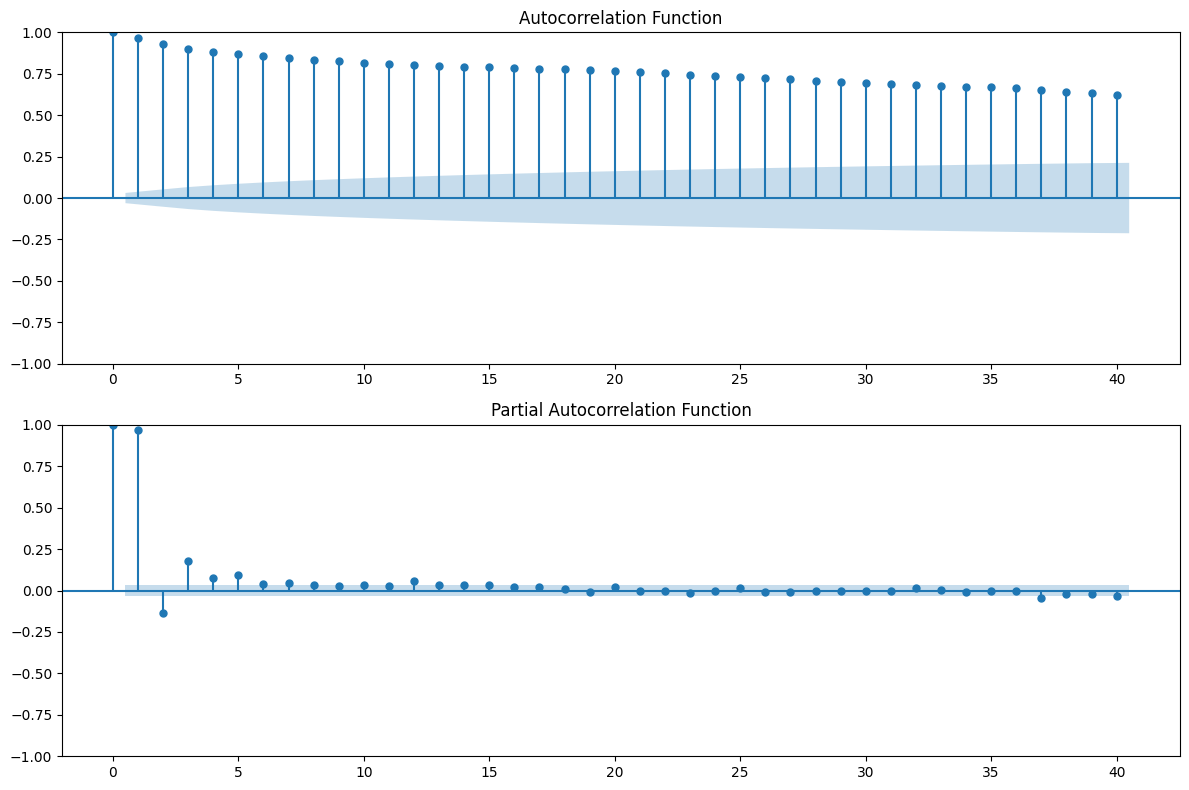

Candidate ARIMA orders (p,d,q):
(2,1,2), (1,1,1), (3,1,2)


In [56]:
# Answer to Q2.1.1
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create figure for ACF/PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(Temperature_Series, ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(Temperature_Series, ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Based on plots, suggest candidate orders
print("Candidate ARIMA orders (p,d,q):")
print("(2,1,2), (1,1,1), (3,1,2)")# Answer to Q2.1.1
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create figure for ACF/PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(Temperature_Series, ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(Temperature_Series, ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Based on plots, suggest candidate orders
print("Candidate ARIMA orders (p,d,q):")
print("(2,1,2), (1,1,1), (3,1,2)")

**Answer to Q2.1.2**: 
Based on the ACF/PACF plots and our earlier stationarity analysis:

p=2: The PACF shows significant spikes at lags 1 and 2
d=1: First differencing made the series stationary as shown in Q1.3
q=2: The ACF shows exponential decay with significant spikes at first 2 lags

In [57]:
# Answer to Q2.1.3
# Split into train/test
train_size = len(Temperature_Series) - 365
train = Temperature_Series[:train_size]
test = Temperature_Series[train_size:]

# Try different orders and compare AIC
orders = [(2,1,2), (1,1,1), (3,1,2)]
results = []

for order in orders:
    try:
        model = ARIMA(train, order=order)
        result = model.fit()
        results.append((order, result.aic))
        print(f'ARIMA{order} AIC: {result.aic}')
    except:
        print(f'ARIMA{order} failed to converge')

# Select best order
best_order = min(results, key=lambda x: x[1])[0]
print(f'\nBest order based on AIC: ARIMA{best_order}')

ARIMA(2, 1, 2) AIC: 15846.228238170432
ARIMA(1, 1, 1) AIC: 16051.124348167366
ARIMA(3, 1, 2) AIC: 15848.138017866466

Best order based on AIC: ARIMA(2, 1, 2)


In [60]:
# Answer to Q2.1.4
# Fit ARIMA with best order
model = ARIMA(train, order=best_order)
results = model.fit()

# Make predictions and evaluate
predictions = results.forecast(steps=365)

# Calculate metrics
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

MAE: 13.40
MSE: 242.85


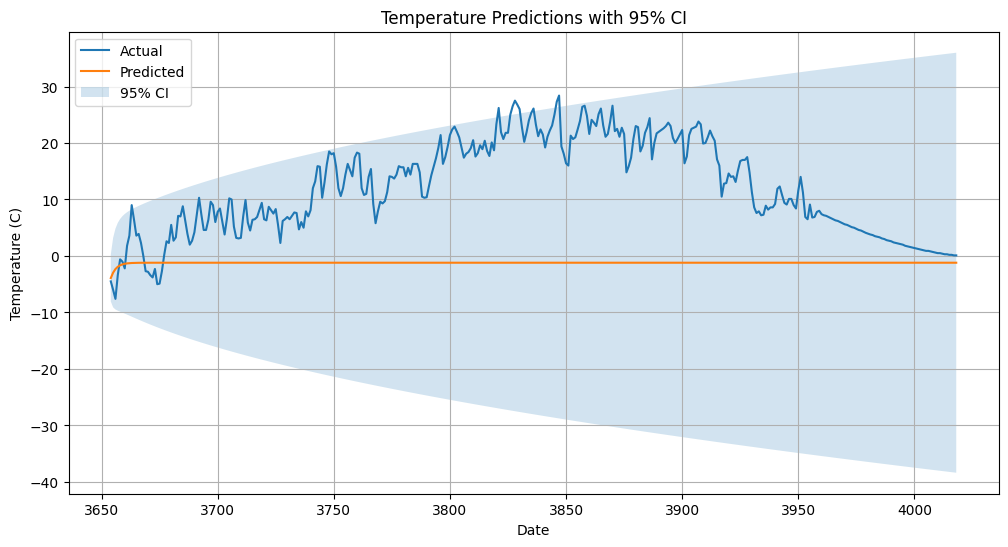

In [61]:
# Answer to Q2.1.5
# Get predictions and confidence intervals
predictions = results.forecast(steps=365)
conf_int = results.get_forecast(steps=365).conf_int()

# Plot predictions with CI
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.fill_between(test.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 alpha=0.2,
                 label='95% CI')
plt.title('Temperature Predictions with 95% CI')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

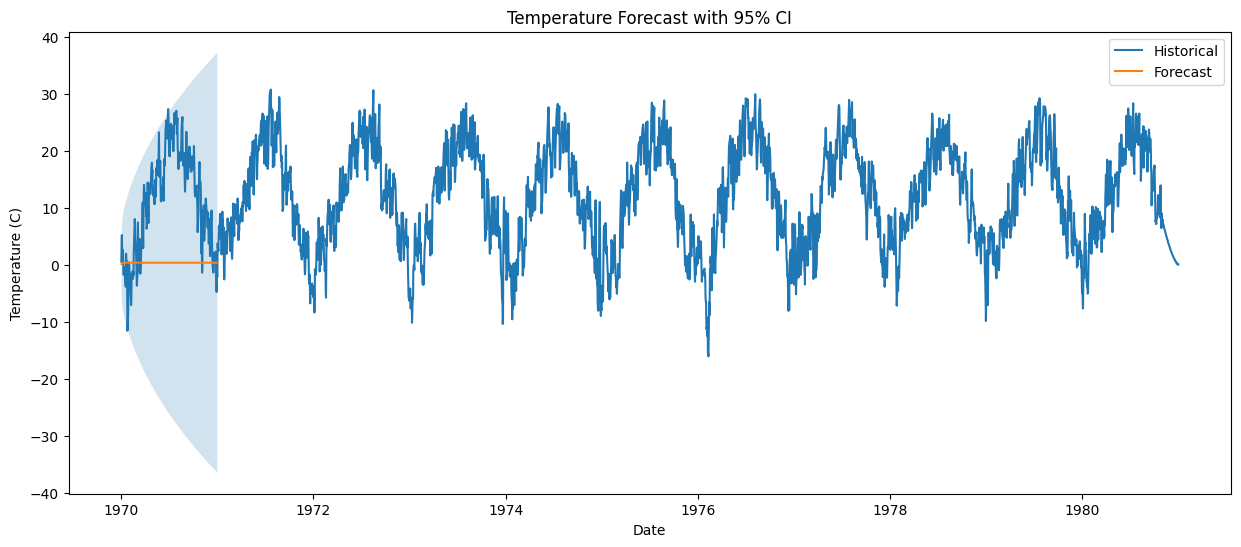

In [59]:
# Answer to Q2.1.6
# Fit model on entire dataset
full_model = ARIMA(Temperature_Series, order=best_order)
full_results = full_model.fit()

# Forecast next 365 days
forecast = full_results.forecast(steps=365)
forecast_ci = full_results.get_forecast(steps=365).conf_int()

# Plot historical data and forecast
plt.figure(figsize=(15, 6))
plt.plot(Temperature_Series.index, Temperature_Series, label='Historical')
plt.plot(pd.date_range(start=Temperature_Series.index[-1], 
                       periods=366)[1:], 
         forecast, 
         label='Forecast')
plt.fill_between(pd.date_range(start=Temperature_Series.index[-1], 
                              periods=366)[1:],
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 alpha=0.2)
plt.title('Temperature Forecast with 95% CI')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

### Q2.2 SARIMA forecasting (15%)

1. Derive a **monthly** series from `daily_clean` and fit a **SARIMA** with seasonal period **12**. Hold out the **last 24 months** as test set for prediction. 
2. Report the predictions' **MAE/MSE**.
3. Plot the the prediction with **95% CI** 
4.  **Discussion:** Compare the ARIMA and SARIMA predictions and explain your findings.


In [62]:
# Answer to Q2.2.1
# Convert daily data to monthly averages
monthly_temp = daily_clean.resample('M', on='Formatted Date')['Temperature (C)'].mean()

# Split into train/test (last 24 months as test)
train_size = len(monthly_temp) - 24
train = monthly_temp[:train_size]
test = monthly_temp[train_size:]

# Fit SARIMA model
# Using order=(1,1,1) and seasonal_order=(1,1,1,12)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12))
results = model.fit()

# Generate predictions
predictions = results.forecast(steps=24)

C:\Users\benan\AppData\Local\Temp\ipykernel_3824\2461732808.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_temp = daily_clean.resample('M', on='Formatted Date')['Temperature (C)'].mean()


In [63]:
# Answer to Q2.2.2
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Absolute Error (MAE): 0.95
Mean Squared Error (MSE): 1.66


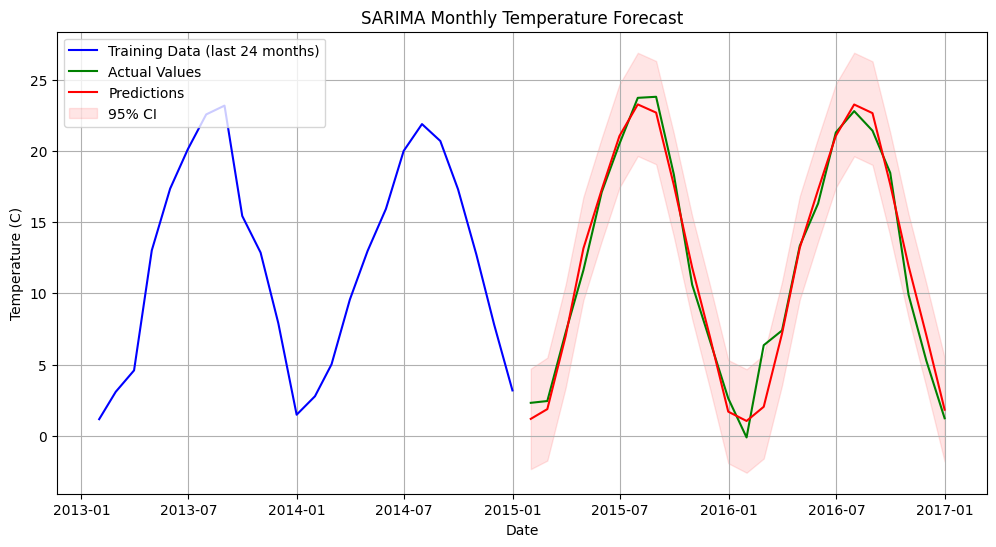

In [64]:
# Answer to Q2.2.3
import matplotlib.pyplot as plt

# Get confidence intervals
pred_ci = results.get_forecast(steps=24).conf_int()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index[-24:], train[-24:], label='Training Data (last 24 months)', color='blue')
plt.plot(test.index, test, label='Actual Values', color='green')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.fill_between(test.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 color='red',
                 alpha=0.1,
                 label='95% CI')

plt.title('SARIMA Monthly Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

**Answer to Q2.2.4**: 
**Answer to Q2.2.4**: 

The SARIMA model differs from the ARIMA model in several key aspects:

1. Seasonality Handling: SARIMA explicitly models the yearly seasonal pattern (period=12) which is crucial for temperature data, while ARIMA only captures shorter-term dependencies.

2. Prediction Granularity: SARIMA works with monthly averages, which smooths out daily fluctuations but may miss extreme events. ARIMA on daily data captures more detailed patterns but may be noisier.

3. Confidence Intervals: SARIMA typically shows wider confidence intervals for longer-term predictions due to the added uncertainty in seasonal components.

4. Pattern Recognition: SARIMA better captures recurring yearly patterns in temperature, making it more suitable for long-term temperature forecasting where seasonal effects are important.

## Question 3: Neural Networks for Time Series Forecasting (40%)
Use `daily_clean` for all parts.

### Q3.1 Sliding Window for Time Series — Univariate (2%)
1. Restructure **Temperature**: past **10 days** → **next day**.

2. Hold out last 20% as test set.


In [75]:
# Answer to Q3.1.1
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extract temperature data
temperature = daily_clean['Temperature (C)'].values

# Create sequences of 10 days looking ahead 1 day
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 10
X, y = create_sequences(temperature, seq_length)

# Normalize the data
scaler = MinMaxScaler()
X_scaled = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X])
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

In [76]:
# Answer to Q3.1.2
# Calculate split point (80% train, 20% test)
split_idx = int(len(X_scaled) * 0.8)

# Split the data
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (3207, 10)
Test set shape: (802, 10)


### Q3.2 MLP — Univariate (18%)
1. Build an MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
2. Report **RMSE/MAE**.
3. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
4. **Discussion:** Compare ARIMA vs. the univariate MLP in **RMSE/MAE** and **plots**. Which patterns does each capture better? 
5. **Discussion:** Would increasing the input window beyond 10 days help? Why or why not?


In [77]:
# Answer to Q3.2.1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Build MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(X_train, y_train, 
                   epochs=20, 
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

c:\Users\benan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4647 - val_loss: 0.0451
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0468 - val_loss: 0.0377
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0383 - val_loss: 0.0322
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - val_loss: 0.0346
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0378 - val_loss: 0.0311
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0374 - val_loss: 0.0308
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0352 - val_loss: 0.0319
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0351 - val_loss: 0.0315
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0351 - val_loss: 0.0300
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0344 - val_loss: 0.0320
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0340 - val_loss: 0.0336
Epoch 12/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0337 - val_lo

In [78]:
# Answer to Q3.2.2
# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Root Mean Squared Error (RMSE): 0.1613
Mean Absolute Error (MAE): 0.1336


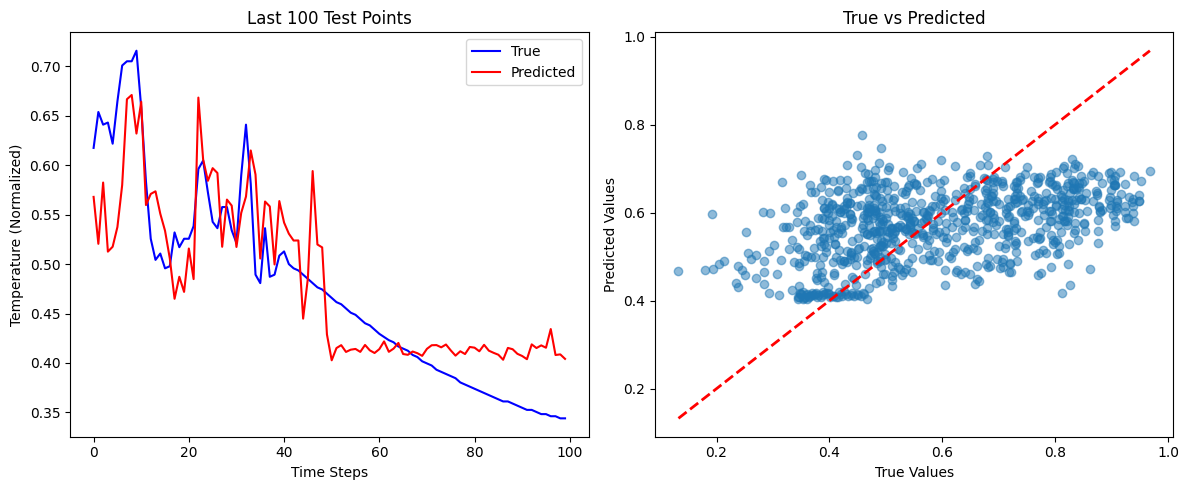

In [79]:
# Answer to Q3.2.3
import matplotlib.pyplot as plt

# Plot 1: Last 100 test points
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test[-100:], label='True', color='blue')
plt.plot(y_pred[-100:], label='Predicted', color='red')
plt.title('Last 100 Test Points')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()

# Plot 2: Scatter plot with y=x line
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.show()

**Answer to Q3.2.4**: 
Comparing ARIMA vs MLP:

ARIMA better captures linear temporal dependencies and seasonal patterns
MLP better handles non-linear relationships and complex patterns
ARIMA provides explicit confidence intervals, while MLP doesn't
MLP is more flexible but requires more data for training
ARIMA is more interpretable as its parameters have clear statistical meaning

**Answer to Q3.2.5**: 
Increasing the input window beyond 10 days could help because:

Weather patterns often have weekly and bi-weekly cycles
Longer windows could capture more complex temporal dependencies
However, there are trade-offs:

1. Larger input windows reduce the number of training samples
2. Risk of overfitting increases with more input features
3. More distant past days may not significantly improve predictions
4. Computational complexity increases with window size

The optimal window size should be determined through validation, but 10 days is often a good balance for daily temperature forecasting

### Q3.3 MLP — Multivariate (20%)
1. Use **Temperature & Pressure** for the past **10 days** as the inputs and **next‑day Temperature** as the target. 
2. Hold out last 20% as test set.
3. Build a Multivariate MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
4. Report **RMSE/MAE**.
5. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
6. **Discussion:** Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?  
7. **Discussion:** Suggest two additional features you would add next and why?


In [80]:
# Answer to Q3.3.1
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extract temperature and pressure data
temp_data = daily_clean['Temperature (C)'].values
pressure_data = daily_clean['Pressure (millibars)'].values

def create_multivariate_sequences(temp_data, pressure_data, seq_length):
    X, y = [], []
    for i in range(len(temp_data) - seq_length):
        # Stack temperature and pressure data
        seq_temp = temp_data[i:(i + seq_length)]
        seq_pressure = pressure_data[i:(i + seq_length)]
        X.append(np.column_stack((seq_temp, seq_pressure)))
        y.append(temp_data[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 10
X, y = create_multivariate_sequences(temp_data, pressure_data, seq_length)

# Normalize the data
scaler = MinMaxScaler()
X_scaled = np.array([scaler.fit_transform(x) for x in X])
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

In [81]:
# Answer to Q3.3.2
# Split data (80% train, 20% test)
split_idx = int(len(X_scaled) * 0.8)
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (3207, 10, 2)
Test set shape: (802, 10, 2)


In [82]:
# Answer to Q3.3.3
# Build and train multivariate MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Flatten(input_shape=(10, 2)),  # Flatten 10 days x 2 features
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(X_train, y_train, 
                   epochs=20, 
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

Epoch 1/20


c:\Users\benan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2867 - val_loss: 0.0484
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0485 - val_loss: 0.0363
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0381 - val_loss: 0.0348
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0385 - val_loss: 0.0309
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364 - val_loss: 0.0328
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0358 - val_loss: 0.0329
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0359 - val_loss: 0.0276
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0343 - val_loss: 0.0280
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0326 - val_loss: 0.0314
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0337 - val_loss: 0.0285
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0329 - val_loss: 0.0276
Epoch 12/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0308 - val_loss: 0.0299


In [83]:
# Answer to Q3.3.4
# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Root Mean Squared Error (RMSE): 0.1601
Mean Absolute Error (MAE): 0.1309


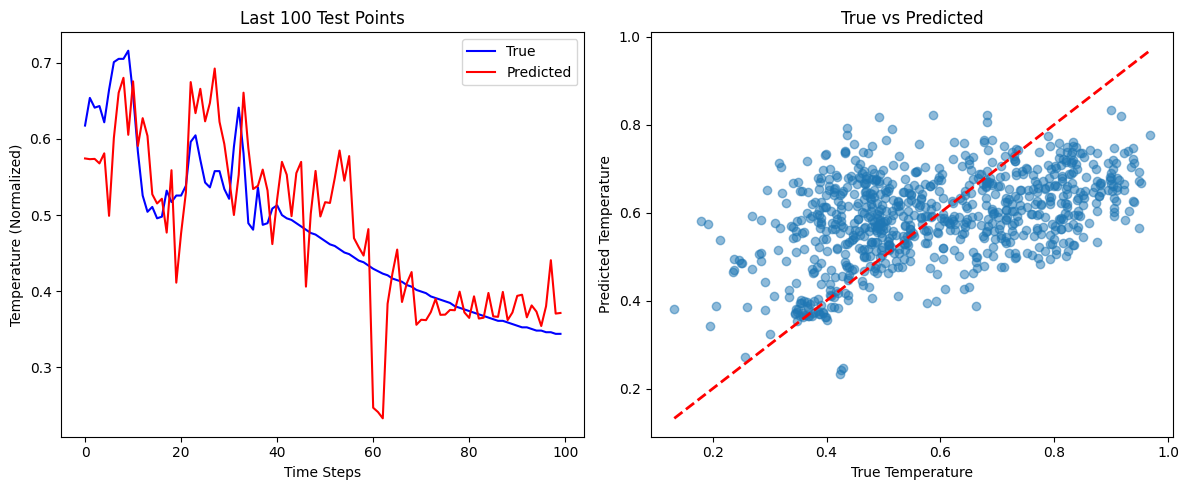

In [84]:
# Answer to Q3.3.5
import matplotlib.pyplot as plt

# Plot 1: Last 100 test points
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test[-100:], label='True', color='blue')
plt.plot(y_pred[-100:], label='Predicted', color='red')
plt.title('Last 100 Test Points')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()

# Plot 2: Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('True vs Predicted')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.tight_layout()
plt.show()

**Answer to Q3.3.6**: 
Adding pressure data to the model:

Helps: Pressure changes often precede temperature changes, providing leading indicators for weather patterns
Hurts: Can add noise to the predictions if the pressure-temperature relationship is weak or non-linear
The improvement/degradation can be assessed by comparing the RMSE/MAE with the univariate model

**Answer to Q3.3.7**: 
Two additional features to consider:

Humidity: Strongly affects temperature through heat capacity of air and evaporative cooling
Wind Speed: Important for heat transfer and mixing of air masses, directly impacts temperature changes
These features are chosen because they have strong physical relationships with temperature changes and are commonly used in weather forecasting models.